Main database Link : 
https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
try:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv('/content/drive/MyDrive/MALIS/project/data/ai4i2020.csv')
except:
    df = pd.read_csv('./data/ai4i2020.csv')

In [36]:
default_figsize = (25,6)

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

***Idea***

Our intent is to first try and understand our Data. We did not chose an already exploitable dataset and thus, we need to modify it in order to have relevant data points.

In [37]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [38]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


Our data is made of sensor history on machines : Temperatures, speed and torque. Along with these sensor data are other information : product info, toolwear, machine failure, failure type


Our goal is to predict when to change the tool so that we maximize lifetime without having any failure.
</br>
Let's try to understand tool wear behaviour :

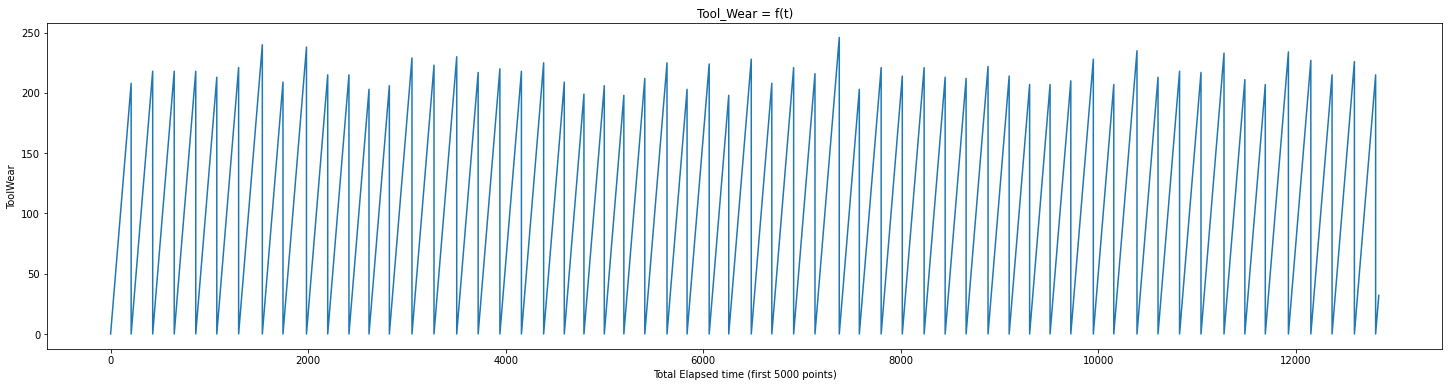

In [39]:
# Computing the total elapsed time for display purposes

totalTime = [0]*10000
for i in range(1,10000):
  if df['Tool wear [min]'][i] == 0:
    totalTime[i] = totalTime[i-1]+df['Tool wear [min]'][i]
  else:
    totalTime[i] = totalTime[i-1] + df['Tool wear [min]'][i]-df['Tool wear [min]'][i-1]
# plt.plot(totalTime)
df['totalTime'] = totalTime

# Let's plot
plt.figure(figsize=default_figsize)
plt.title("Tool_Wear = f(t)")
plt.ylabel("ToolWear")
plt.xlabel("Total Elapsed time (first 5000 points)")
plt.plot([df['totalTime'][i] for i in range(5000)], df['Tool wear [min]'][:5000])

And if we take the problem in the other way around, we can compute and draw the time before the tool breaks:

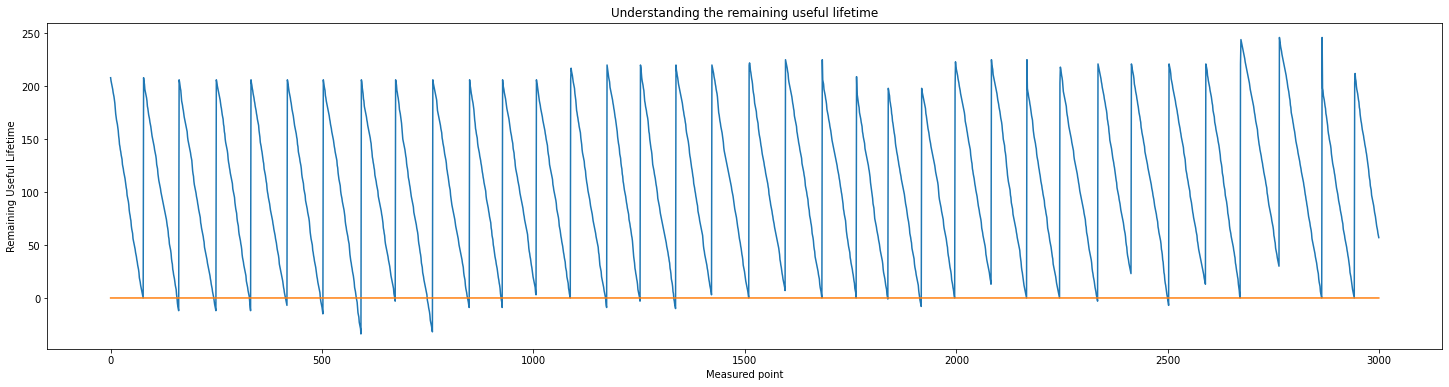

In [40]:
y = []
length=3000

UDI_breaks = []
for i in df.UDI:
  if df.TWF[i-1] == 1:
    UDI_breaks.append(i)
# print(UDI_breaks)
UDI_breaks_iterator = iter(UDI_breaks)
actual_break_UDI = next(UDI_breaks_iterator)

for i in range(length):
  if i > actual_break_UDI:
    # print(actual_break_UDI)
    actual_break_UDI = next(UDI_breaks_iterator)
  y.append(df['Tool wear [min]'][actual_break_UDI-1] - df['Tool wear [min]'][i])


# Plotting the results
plt.figure(figsize=default_figsize)
plt.title("Understanding the remaining useful lifetime")
plt.ylabel("Remaining Useful Lifetime")
plt.xlabel("Measured point")
plt.plot(y)
plt.plot([0]*length)

Let's have a closer look at our distribution of failure point. Let's compute the mean interval between two tool failures and the variance of it:

Tool wear failure interval distribution

Mean:               216.3695652173913 min
Variance:           146.97211720226844 min
Standard Deviation:  12.123205731252293 min


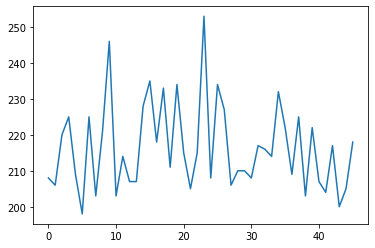

In [41]:
intervals_length = []
for i in df.UDI:
  if df.TWF[i-1] == 1:
    intervals_length.append(df['Tool wear [min]'][i-1])

plt.plot([i for i in range(len(intervals_length))], intervals_length)

intervals_length = np.array(intervals_length)
print("Tool wear failure interval distribution")
print()
print("Mean:               {} min".format(np.mean(intervals_length)))
print("Variance:           {} min".format(np.var(intervals_length)))
print("Standard Deviation:  {} min".format(np.std(intervals_length)))


These previous results will be useful in determining wether our algorithm works or not (prediction MSE should be inferior to standard deviation)

Since our dataset if just made of one-off sensor measures, they do not take into account the tool history. Nevertheless, knowing the history of the tool may actually be useful in determining it's break point. Let's then create a "Cumulative" dataframe which will take into account our tool histories.

We will start with cumulative Torque and RPM only : 

In [42]:
data = {
    'Torque':[0]*9999,
    'Rpm':[0]*9999,
    'ToolWear':[0]*9999,
    'Failure':[0]*9999
}
cumulative_df = pd.DataFrame(data)
lastChangePoint = 0
for i in range(9999):
  cumulative_df['ToolWear'][i] = df['Tool wear [min]'][i]
  if df['Tool wear [min]'][i] == 0:
    cumulative_df['Torque'][i] = df['Torque [Nm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i])
    cumulative_df['Rpm'][i] = df['Rotational speed [rpm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i])
  else:
    cumulative_df['Torque'][i] = df['Torque [Nm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i]) + cumulative_df['Torque'][i-1]
    cumulative_df['Rpm'][i] = df['Rotational speed [rpm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i]) + cumulative_df['Rpm'][i-1]
  if df['TWF'][i]==1:
    cumulative_df['Failure'][i]=1
  else:
    cumulative_df['Failure'][i]=0

  

In [43]:
cumulative_df.head(80)

,Torque,Rpm,ToolWear,Failure
0,128,4653,0,0
1,220,7469,3,0
2,318,10465,5,0
3,397,13331,7,0
4,477,16147,9,0
...,...,...,...,...
75,8179,317700,204,0
76,8274,320622,206,0
77,8274,320622,208,1
78,103,2796,0,0


Let's split in a training and test dataset:

In [44]:
X_train, X_test, y_train, y_test=train_test_split(cumulative_df.drop(['Failure'], axis=1), cumulative_df[['Failure']], test_size=4000)

Let's first try a Logistic regression on the cumulative torque and rpm to predict if there is a tool failure or not.

In [45]:
LR_model_1 = LogisticRegression(solver='liblinear', max_iter=2000)
LR_model_1.fit(X_train, np.ravel(np.array(y_train)));

In [46]:
X_train, X_test, y_train, y_test=train_test_split(cumulative_df.drop(['Failure'], axis=1), cumulative_df[['Failure']], test_size=4000)

LR_model_1.fit(X_train, np.ravel(np.array(y_train)));

def predict_and_test(LR_model,X,y):
  y_hat = LR_model.predict(X)
  y = np.array(y)
  corrects = 0
  corrects_0 = 0
  count_1 = 0
  count_0 = 0
  for i in range(len(y)):
    if (y[i] == 1):
      count_1 += 1
      if(y_hat[i] == y[i]):
        corrects+=1
    if (y[i]==0):
      count_0 += 1
      if (y_hat[i] == y[i]):
        corrects_0 += 1
  print(count_1)
  return (corrects/count_1,corrects_0/count_0)


accuracy_training = predict_and_test(LR_model_1,X_test,y_test)
print(accuracy_training)
print(np.sum(np.array(y_test))/len(y_test))

17
(0.0, 1.0)
0.00425


We are not getting any results for now because there is way too many 0 compared to 1 in y_test. We should try to diminish the ratio 0/1 by only keeping the one just before the failure.

Let's add a column that compute the RUL to the dataframe in order to try the regression.

In [47]:
RUL = []

toolChanges = []
for i in range(1,10000):
  if df['Tool wear [min]'][i-1] == 0:
    toolChanges.append(i-2)
iterator = iter(toolChanges)
actual = next(iterator)

for i in range(9999):
  if i > actual:
    actual = next(iterator,9999)
  RUL.append(df['Tool wear [min]'][actual] - df['Tool wear [min]'][i])


cumulative_df['RUL']=RUL

print(cumulative_df.head())

   Torque    Rpm  ToolWear  Failure  RUL
0     128   4653         0        0  208
1     220   7469         3        0  205
2     318  10465         5        0  203
3     397  13331         7        0  201
4     477  16147         9        0  199


Try a linear regression now:

In [48]:
from sklearn.linear_model import LinearRegression

[160 227  22 ... 186  36  59]


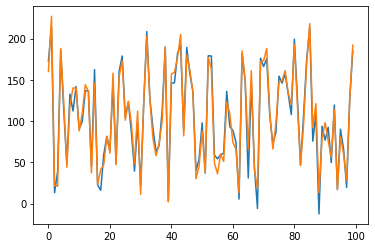

In [49]:
X_train, X_test, y_train, y_test=train_test_split(cumulative_df.drop(['Failure','RUL'], axis=1), cumulative_df[['RUL']], test_size=4000)
X_train,X_test,y_train, y_test = np.array(X_train), np.array(X_test), np.ravel(np.array(y_train)),np.ravel(np.array(y_test))
reg = LinearRegression().fit(X_train,y_train)
y_hat = reg.predict(X_test)
abscissas = [i for i in range(100)]
plt.plot(abscissas,y_hat[:100])
plt.plot(abscissas,y_test[:100])
print(y_test)

In [50]:
print(reg.score(X_train,y_train))

0.9644649035814788


Calculons la MSE:

In [51]:
MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print(MSE)

148.25619139897324


What interests us is the low RULs so let's compute the MSEl for points with low RULs let's see the MSE for points with RUL <= 40

In [52]:
treshold = 40
sum = 0
count = 0
for i in range(len(y_test)):
  if (y_test[i]<=treshold):
    sum += (y_hat[i]-y_test[i])**2
  count += 1
MSEl = sum/count
print(MSEl)

53.796845915567516


We see that the MSE for points with low RULs is quite better.

Let's try to train the model on points with low RULs:

98.34270918920768


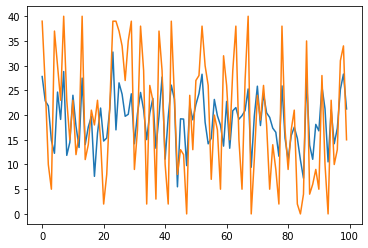

In [53]:
cumulative_onlyLowRul_df = cumulative_df.copy()
cumulative_onlyLowRul_df = cumulative_onlyLowRul_df[cumulative_onlyLowRul_df['RUL'] <= 40]

X_train, X_test, y_train, y_test=train_test_split(cumulative_onlyLowRul_df.drop(['Failure','RUL'], axis=1), cumulative_onlyLowRul_df[['RUL']], test_size=int(0.4*len(cumulative_onlyLowRul_df)))
X_train,X_test,y_train, y_test = np.array(X_train), np.array(X_test), np.ravel(np.array(y_train)),np.ravel(np.array(y_test))
regLow = LinearRegression().fit(X_train,y_train)
y_hat = regLow.predict(X_test)
abscissas = [i for i in range(100)]
plt.plot(abscissas,y_hat[:100])
plt.plot(abscissas,y_test[:100])

MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print(MSE)

The results are worse with only low RULs on the training

Let's try with only the Torque*time:

Torque      int64
Rpm         int64
ToolWear    int64
dtype: object
[223  16  26 ... 110  33  12]
MSE for Torque, ToolWear and Rpm : 136.10161955980334
[223  16  26 ... 110  33  12]
MSE for only Torque and ToolWear : 136.43158194680274
[223  16  26 ... 110  33  12]
MSE for only ToolWear : 137.51591256535235


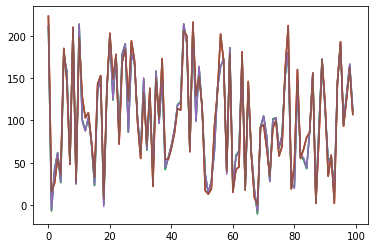

In [54]:

X_train_df, X_test_df, y_train_df, y_test_df=train_test_split(cumulative_df.drop(['Failure','RUL'], axis=1), cumulative_df[['RUL']], test_size=4000)
print(X_train_df.dtypes)
X_train_onlyTorque, X_test_onlyTorque = np.array(X_train_df.drop(['Rpm'],axis=1)), np.array(X_test_df.drop(['Rpm'],axis=1))

X_train,X_test,y_train, y_test = np.array(X_train_df), np.array(X_test_df), np.ravel(np.array(y_train_df)),np.ravel(np.array(y_test_df))
reg = LinearRegression().fit(X_train,y_train)
y_hat = reg.predict(X_test)
abscissas = [i for i in range(100)]
plt.plot(abscissas,y_hat[:100])
plt.plot(abscissas,y_test[:100])
print(y_test)
MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print("MSE for Torque, ToolWear and Rpm : " + str(MSE))

reg = LinearRegression().fit(X_train_onlyTorque,y_train)
y_hat = reg.predict(X_test_onlyTorque)
abscissas = [i for i in range(100)]
plt.plot(abscissas,y_hat[:100])
plt.plot(abscissas,y_test[:100])
print(y_test)
MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print("MSE for only Torque and ToolWear : " + str(MSE))

#Let's see if we only keep the tool Wear
X_train_onlyTorque, X_test_onlyTorque = np.array(X_train_df.drop(['Rpm','Torque'],axis=1)), np.array(X_test_df.drop(['Rpm','Torque'],axis=1))

reg = LinearRegression().fit(X_train_onlyTorque,y_train)
y_hat = reg.predict(X_test_onlyTorque)
abscissas = [i for i in range(100)]
plt.plot(abscissas,y_hat[:100])
plt.plot(abscissas,y_test[:100])
print(y_test)
MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print("MSE for only ToolWear : " + str(MSE))

Let's take consecutive datas:

Torque      int64
Rpm         int64
ToolWear    int64
dtype: object
MSE for Torque, ToolWear and Rpm : 184.3224012454779
MSE for only Torque and ToolWear : 184.64873049237025
MSE for only ToolWear : 184.77552562517306


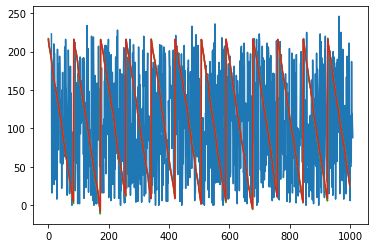

In [55]:

X_train_df, X_test_df, y_train_df, y_test_df=cumulative_df[:6000].drop(['Failure','RUL'], axis=1),cumulative_df[6000:].drop(['Failure','RUL'], axis=1),cumulative_df[['RUL']][:6000],cumulative_df[['RUL']][6000:]
print(X_train_df.dtypes)
X_train_onlyTorque, X_test_onlyTorque = np.array(X_train_df.drop(['Rpm'],axis=1)), np.array(X_test_df.drop(['Rpm'],axis=1))

aff_len = 1000
abscissas = [i for i in range(aff_len)]
abscissas_shift = [i+10 for i in range(aff_len)]

plt.plot(abscissas_shift,y_test[:aff_len])

X_train,X_test,y_train, y_test = np.array(X_train_df), np.array(X_test_df), np.ravel(np.array(y_train_df)),np.ravel(np.array(y_test_df))
reg = LinearRegression().fit(X_train,y_train)
y_hat = reg.predict(X_test)
plt.plot(abscissas,y_hat[:aff_len])
MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print("MSE for Torque, ToolWear and Rpm : " + str(MSE))

reg = LinearRegression().fit(X_train_onlyTorque,y_train)
y_hat = reg.predict(X_test_onlyTorque)

plt.plot(abscissas,y_hat[:aff_len])
MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print("MSE for only Torque and ToolWear : " + str(MSE))

#Let's see if we only keep the tool Wear
X_train_onlyTorque, X_test_onlyTorque = np.array(X_train_df.drop(['Rpm','Torque'],axis=1)), np.array(X_test_df.drop(['Rpm','Torque'],axis=1))

reg = LinearRegression().fit(X_train_onlyTorque,y_train)
y_hat = reg.predict(X_test_onlyTorque)
plt.plot(abscissas,y_hat[:aff_len])
MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print("MSE for only ToolWear : " + str(MSE))

In [56]:
change = cumulative_df[['ToolWear','Torque','Rpm']].iloc[toolChanges[1:]][cumulative_df['ToolWear']>200]
not_toolChanges = [i for i in range(9999)]
for i in toolChanges[1:]:
  del not_toolChanges[not_toolChanges.index(i)]
not_change = cumulative_df[['ToolWear','Torque','Rpm']].iloc[not_toolChanges][cumulative_df['ToolWear']>200]

/tmp/ipykernel_18657/1531508394.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  change = cumulative_df[['ToolWear','Torque','Rpm']].iloc[toolChanges[1:]][cumulative_df['ToolWear']>200]
/tmp/ipykernel_18657/1531508394.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  not_change = cumulative_df[['ToolWear','Torque','Rpm']].iloc[not_toolChanges][cumulative_df['ToolWear']>200]


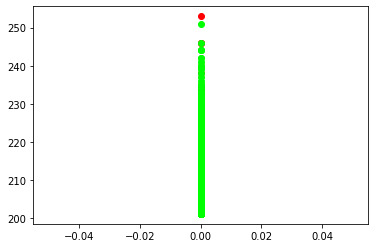

In [57]:
plt.scatter([0 for i in range(len(change))],change['ToolWear'],c='#FF0000')
plt.scatter([0 for i in range(len(not_change))],not_change['ToolWear'],c='#00FF00')

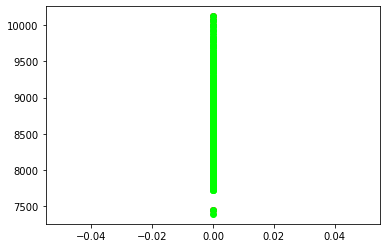

In [58]:
plt.scatter([0 for i in range(len(change))],change['Torque'],c='#FF0000')
plt.scatter([0 for i in range(len(not_change))],not_change['Torque'],c='#00FF00')

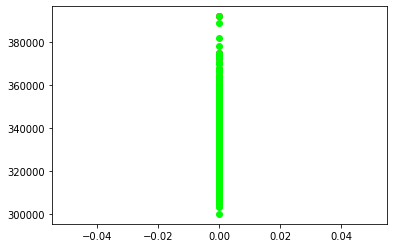

In [59]:
plt.scatter([0 for i in range(len(change))],change['Rpm'],c='#FF0000')
plt.scatter([0 for i in range(len(not_change))],not_change['Rpm'],c='#00FF00')

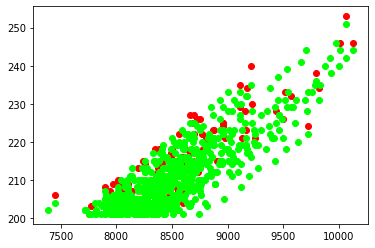

In [60]:
plt.scatter(change['Torque'],change['ToolWear'],c='#FF0000')
plt.scatter(not_change['Torque'],not_change['ToolWear'],c='#00FF00')

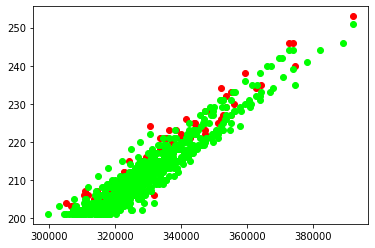

In [61]:
plt.scatter(change['Rpm'],change['ToolWear'],c='#FF0000')
plt.scatter(not_change['Rpm'],not_change['ToolWear'],c='#00FF00')

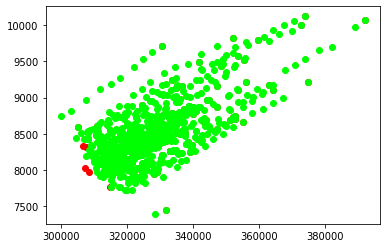

In [62]:
plt.scatter(change['Rpm'],change['Torque'],c='#FF0000')
plt.scatter(not_change['Rpm'],not_change['Torque'],c='#00FF00')

Text(0.5, 0, 'ToolWear')

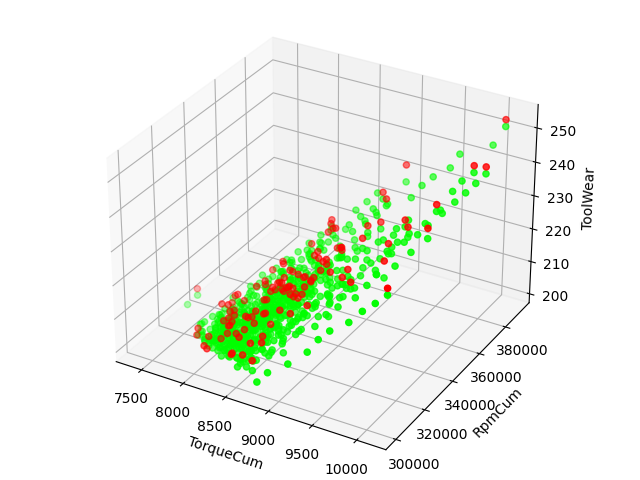

In [63]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter3D(change['Torque'],change['Rpm'],change['ToolWear'],c='#FF0000')
ax.scatter3D(not_change['Torque'],not_change['Rpm'],not_change['ToolWear'],c='#00FF00')
ax.set_title("Tool change in function of RpmCum TorqueCum and ToolWear")
ax.set_xlabel('TorqueCum')
ax.set_ylabel('RpmCum')
ax.set_zlabel('ToolWear')


***Separability***
Given a certain angle, there is a clear linear separability using these three features. Here is below a screenshot taken at the right angle : 

<img src='./images/data_separability.png' height=300px>

In [64]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

Let's try a SVM to exploit this linearly separability.
We will first focus on the low RULs point to see what we get:

In [65]:
data = {
    'Torque':[0]*9999,
    'Rpm':[0]*9999,
    'ToolWear':[0]*9999,
    'ToolChange':[0]*9999
}
cumulative_df = pd.DataFrame(data)
lastChangePoint = 0
for i in range(9999):
  cumulative_df['ToolWear'][i] = df['Tool wear [min]'][i]
  if df['Tool wear [min]'][i] == 0:
    cumulative_df['Torque'][i] = df['Torque [Nm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i]) / 10
    cumulative_df['Rpm'][i] = df['Rotational speed [rpm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i]) / 1000
  else:
    cumulative_df['Torque'][i] = df['Torque [Nm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i]) / 10 + cumulative_df['Torque'][i-1]
    cumulative_df['Rpm'][i] = df['Rotational speed [rpm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i])  / 1000 + cumulative_df['Rpm'][i-1] 
  if df['Tool wear [min]'][i+1]==0:
    cumulative_df['ToolChange'][i]=1
  else:
    cumulative_df['ToolChange'][i]=0


cumulative_df_onlyLowRul = cumulative_df[cumulative_df['ToolWear']>180]

In [66]:

nbLowRuls = len(cumulative_df_onlyLowRul)
print(nbLowRuls)
cumulative_df_onlyLowRul.describe()


1678


,Torque,Rpm,ToolWear,ToolChange
count,1678.000000,1678.000000,1678.000000,1678.000000
mean,772.844458,272.030393,200.294398,0.070918
std,56.234115,18.395176,13.177124,0.256764
min,638.000000,233.000000,181.000000,0.000000
25%,732.000000,258.000000,190.000000,0.000000
50%,766.000000,270.000000,199.000000,0.000000
75%,807.000000,283.750000,209.000000,0.000000
max,970.000000,352.000000,253.000000,1.000000


In [67]:
lenTrainSet = round(nbLowRuls*0.6)
lenTestSet = nbLowRuls - lenTrainSet
X_trainSVM_df,X_testSVM_df,y_trainSVM_df,y_testSVM_df = cumulative_df_onlyLowRul[['Torque','Rpm','ToolWear']][:lenTrainSet],cumulative_df_onlyLowRul[['Torque','Rpm','ToolWear']][lenTrainSet:],cumulative_df_onlyLowRul[['ToolChange']][:lenTrainSet],cumulative_df_onlyLowRul[['ToolChange']][lenTrainSet:]
X_trainSVM,X_testSVM,y_trainSVM, y_testSVM = np.array(X_trainSVM_df), np.array(X_testSVM_df), np.ravel(np.array(y_trainSVM_df)),np.ravel(np.array(y_testSVM_df))
# print(y_trainSVM)
X_testSVM_df.describe()

,Torque,Rpm,ToolWear
count,671.000000,671.000000,671.000000
mean,770.332340,270.612519,199.473920
std,56.543747,16.750284,12.472614
min,638.000000,233.000000,181.000000
25%,730.000000,257.000000,189.500000
50%,765.000000,269.000000,198.000000
75%,804.000000,283.000000,208.000000
max,970.000000,328.000000,246.000000


In [68]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.simplefilter("ignore")
from sklearn.exceptions import ConvergenceWarning

In [70]:
classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(solver='liblinear', max_iter=400),
    SVC(kernel="linear", C=500),
    # SVC(kernel="rbf", gamma=2, C=1),
    # DecisionTreeClassifier(max_depth=5),
    # MLPClassifier(learning_rate_init=0.05, max_iter=3000, hidden_layer_sizes=(10), batch_size=60, learning_rate='constant',  activation='logistic', solver='sgd', tol=-10.),
    # MLPClassifier(learning_rate_init=0.05, max_iter=4000, hidden_layer_sizes=(10, 10), batch_size=60, learning_rate='constant', activation='logistic', solver='sgd', tol=-10.)
    ]

for clf in classifiers:
    print(clf.fit(X_trainSVM,y_trainSVM))
    score = clf.score(X_testSVM,y_testSVM)
    print("Score = " + str(score))

print(len(X_train))

KNeighborsClassifier(n_neighbors=3)
Score = 0.9210134128166915
LogisticRegression(max_iter=400, solver='liblinear')
Score = 0.9344262295081968
SVC(C=500, kernel='linear')
Score = 0.9239940387481371
6000


In [ ]:
print(len(change), len(not_change), len(change)/len(not_change))

115 647 0.1777434312210201


In [77]:
simple_df = df[["Torque [Nm]", "Rotational speed [rpm]", "Tool wear [min]", "Machine failure"]]

output_df=simple_df['Machine failure'].copy()  #Step 2
input_df=simple_df.drop(['Machine failure'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.25)


tree = DecisionTreeClassifier(max_depth=5)
print(tree.fit(X_train,y_train))
score = tree.score(X_test,y_test)
print("Score = " + str(score))

      Torque [Nm]  Rotational speed [rpm]  Tool wear [min]
8370         33.6                    1634               27
3308         43.4                    1433               86
3320         16.4                    2289              112
1160         23.8                    1834              195
6666         51.4                    1414              199
DecisionTreeClassifier(max_depth=5)
Score = 0.9776
